In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


## Imports..

In [2]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Config..

In [3]:
%matplotlib inline

## Analysis..

In [4]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

len(train_df), len(test_df)

(42000, 28000)

In [5]:
# sample rows

print(train_df.head())
print(test_df.head())

   label  pixel0  pixel1    ...     pixel781  pixel782  pixel783
0      1       0       0    ...            0         0         0
1      0       0       0    ...            0         0         0
2      1       0       0    ...            0         0         0
3      4       0       0    ...            0         0         0
4      0       0       0    ...            0         0         0

[5 rows x 785 columns]
   pixel0  pixel1  pixel2    ...     pixel781  pixel782  pixel783
0       0       0       0    ...            0         0         0
1       0       0       0    ...            0         0         0
2       0       0       0    ...            0         0         0
3       0       0       0    ...            0         0         0
4       0       0       0    ...            0         0         0

[5 rows x 784 columns]


**Observations**
1. Training data consists of "label" and 784 pixel values as column names ranging from "pixel0" to "pixel783"
2. Test has just 784 columns with all pixel values without labels

In [6]:
28*28

784

**Observations**
1. Each row is an image with 28 pixels width and 28 pixels height. Each pixel ranges from (0, 255) representing grayscale

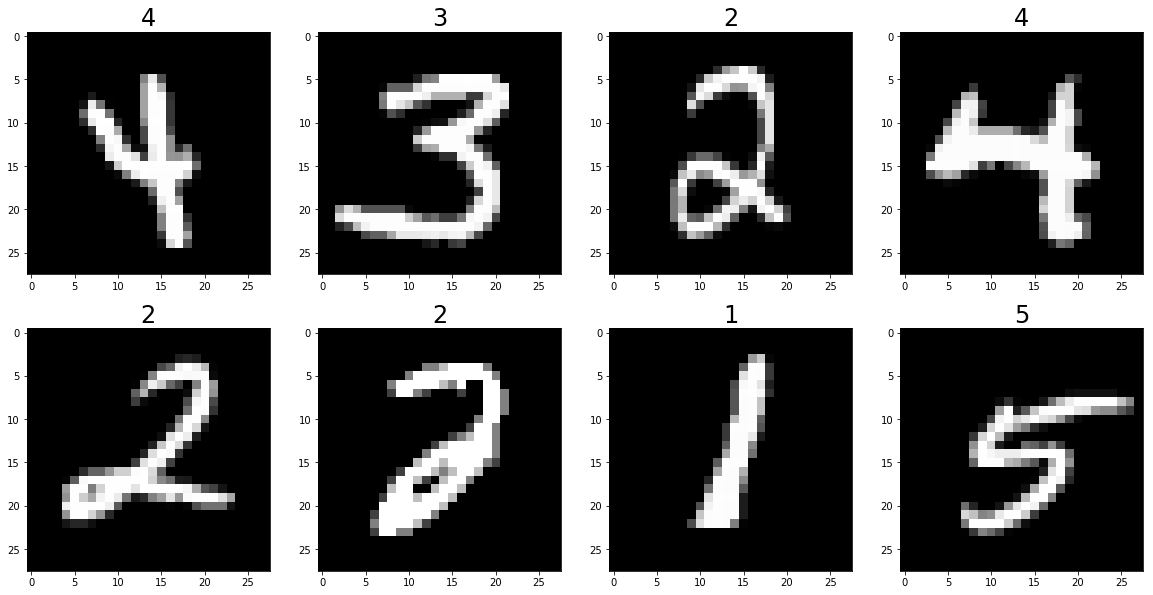

In [7]:
# sample train images

np.random.seed(13)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
random_rows = np.random.choice(train_df.index, size=8, replace=False)
for ax, idx in zip(axes.flat, random_rows):
    row = train_df.iloc[idx, 1:].values
    img_matrix = row.reshape(28, 28)
    ax.imshow(img_matrix, cmap="gray")
    ax.set_title(train_df.iloc[idx, 0], fontdict={"fontsize": 24})

**Observations**
1. **2** at position (2, 2) and **4** at (1, 1) are difficult for a human to judge as well

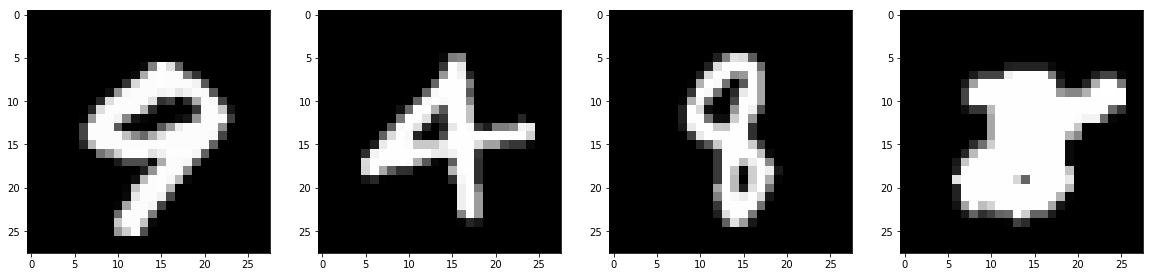

In [8]:
# sample test images

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
np.random.seed(13)
random_rows = np.random.choice(test_df.index, size=4, replace=False)
for ax, idx in zip(axes.flat, random_rows):
    row = test_df.iloc[idx, :]
    ax.imshow(row.values.reshape(28, 28), cmap="gray")

**Observations**
1. Any guess what is at (1, 4)... 8 probably??

## Model building

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Activation
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


**Observations**
1. Rescaling inputs is essential especially when using RELU's.

In [10]:
# rescale inputs
train_df.iloc[:, 1:] /= 255
test_df /= 255

train_inputs = train_df.iloc[:, 1:].values.reshape(len(train_df), 28, 28, 1)
test_inputs = test_df.iloc[:, :].values.reshape(len(test_df), 28, 28, 1)

train_inputs.shape, test_inputs.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

One hot encode the "label" column to represent each value with a vector of size 10

In [11]:
one_hot_labels = to_categorical(train_df.label.values, num_classes=10)
one_hot_labels[: 5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
# Split train - validation
X_train, X_val, y_train, y_val = train_test_split(train_inputs, one_hot_labels, test_size=0.2, random_state=13)

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), name="conv1", padding="same"))
model.add(Activation("relu", name="act1"))
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), name="conv2", padding="same"))
model.add(Activation("relu", name="act2"))
model.add(MaxPool2D((2, 2), name="mpool1"))
model.add(Dropout(0.25, name="drop1"))

model.add(Conv2D(64, (3, 3), name="conv3", padding="same"))
model.add(Activation("relu", name="act3"))
model.add(Conv2D(64, (3, 3), name="conv4", padding="same"))
model.add(Activation("relu", name="act4"))
model.add(MaxPool2D((2, 2), name="mpool2"))
model.add(Dropout(0.25, name="drop2"))

model.add(Flatten(name="flat1"))
model.add(BatchNormalization(name="bn1"))
model.add(Dense(512, activation="relu", name="dense1"))
model.add(Dropout(0.5, name="drop3"))

model.add(Dense(10, activation="softmax", name="softmax"))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
mpool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 64)        18496     
__________

In [15]:
# Using Keras 'ImageDataGenerator'. Function returns a generator with images transformed
datagen = ImageDataGenerator(zoom_range = 0.1,
                             height_shift_range = 0.1,
                             width_shift_range = 0.1,
                             rotation_range = 10)
datagen.fit(X_train)

In [16]:
# By using Keras callbacks, we can control the learning rate automatically while model is getting built
# Below ReduceLROnPlateau decreases learning rate based on change in validation accuracy
# patience - waits for 3 epochs
# min_lr - if learning rate is not changed by "min_lr" amount
# factor - existing learning rate by this value

lr_reduce = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, verbose=1, min_lr=0.00001)

In [17]:
model.compile(optimizer=Adam(), metrics=["accuracy"], loss="categorical_crossentropy")
model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_val, y_val), epochs=100, callbacks=[lr_reduce], verbose=1)

Epoch 1/100
525/525 [==============================] - 18s 35ms/step - loss: 0.3111 - acc: 0.8996 - val_loss: 0.1123 - val_acc: 0.9694
Epoch 2/100
525/525 [==============================] - 15s 28ms/step - loss: 0.1231 - acc: 0.9623 - val_loss: 0.0619 - val_acc: 0.9835
Epoch 3/100
525/525 [==============================] - 15s 28ms/step - loss: 0.0987 - acc: 0.9697 - val_loss: 0.0620 - val_acc: 0.9844
Epoch 4/100
525/525 [==============================] - 15s 28ms/step - loss: 0.0843 - acc: 0.9749 - val_loss: 0.0656 - val_acc: 0.9833
Epoch 5/100
525/525 [==============================] - 15s 28ms/step - loss: 0.0832 - acc: 0.9750 - val_loss: 0.0546 - val_acc: 0.9861
Epoch 6/100
525/525 [==============================] - 15s 28ms/step - loss: 0.0816 - acc: 0.9774 - val_loss: 0.0390 - val_acc: 0.9906
Epoch 7/100
525/525 [==============================] - 15s 29ms/step - loss: 0.0783 - acc: 0.9776 - val_loss: 0.0559 - val_acc: 0.9899
Epoch 8/100
525/525 [==============================] - 

In [18]:
# predictions
test_preds = model.predict(test_inputs)
test_labels = np.argmax(test_preds, axis=1)
test_labels[:5]

array([2, 0, 9, 0, 3])

In [19]:
# submission dataframe
sub_df = pd.concat([pd.Series(range(1, 28001), name="ImageId"), pd.Series(test_labels, name="Label")], axis=1)

# save submission
sub_df.to_csv('submission.csv', index=False)